In [2]:
import ast
import pandas as pd
from environment import CompetitivePerishableInventoryPlanning
from nash_q_learning import nash_q_learning
from utils import combinations, interpolate
import numpy as np
import nashpy as nash
import utils

np.random.seed(40)

In [3]:
def negate_nashq_matrices(Q1, Q2):
      BigM = 10**10
      Q1_negated = Q1.copy()
      Q1_negated[Q1_negated == 0] = BigM
      Q2_negated = Q2.copy()
      Q2_negated[Q2_negated == 0] = BigM

      return -Q1_negated, -Q2_negated

In [4]:
def get_best_policy_comparison(Q1_Nash, Q2_Nash, demand_lambda = 3):
    np.random.seed(40)
    current_state_dp = env.initial_state
    current_state_nq = env.initial_state
    demand_arr = []
    policy1_dp = []
    policy1_nq = []
    policy2 = []
    cost1_arr_dp = []
    cost1_arr_nq = []
    cost2_arr_dp = []
    cost2_arr_nq = []
    fulfillment_arr_dp = []
    fulfillment_arr_nq = []
    t = 0
    x1_dp = 0
    x1_nq = 0
    x2 = 0
    total_cost_1_dp = 0
    total_cost_1_nq = 0
    total_cost_2_dp = 0
    total_cost_2_nq = 0
    while t != env.T:
        # print("- t:",t)
        # Dt = demand_arr[t]
        Dt = min(env.max_x, np.random.poisson(demand_lambda))
        demand_arr.append(Dt)
        # print("Current state of DP:", current_state_dp)
        # print("Current state of NashQLearning:", current_state_nq)
        St1_dp, St2_dp = current_state_dp
        St1_nq, St2_nq = current_state_nq
        St1_dp_t = tuple(St1_dp)
        St2_dp_t = tuple(St2_dp)

        # NashQLearning Policy Selection
        s_ind_nq = state_index.loc[state_index["state"].apply(lambda x: np.array_equal(x, current_state_nq))].index[0]

        q_state1 = Q1_Nash[s_ind_nq, t, :, 3].reshape(-1, 1)
        q_state2 = Q2_Nash[s_ind_nq, t, :, 3].reshape(-1, 1)

        game = nash.Game(q_state1,q_state2)
        equilibriums = list(game.support_enumeration())
        best_payoff = -np.Inf
        for eq in equilibriums:
                 if len(np.where(eq[0] == 1)[0]) != 0: #The equilibrium needs to be a strict nash equilibrium (no mixed-strategy)
                     total_payoff = q_state1[np.where(eq[0]==1)[0][0]][np.where(eq[1]==1)[0][0]] + q_state2[np.where(eq[0]==1)[0][0]][np.where(eq[1]==1)[0][0]]
                     if (total_payoff < 0) and (total_payoff >= best_payoff):
                         best_payoff = total_payoff
                         x1_nq = np.where(eq[0] == 1)[0][0]
                         x2 = 3
        if t != env.T:
                policy1_nq.append(x1_nq)
        else :  #the model did not converge
                policy0 = 'model failed to converge to a policy'
                policy1 = 'model failed to converge to a policy'
                break    
        
        # Inventory updates with replenishments
        St_nq_wt_replenishment = utils.update_initial_inventory_states(current_state_nq, [x1_nq, x2])
        St1_nq, St2_nq = St_nq_wt_replenishment

        
        fulfillment_metric_nq = utils.calculate_fulfillment_metric(St_nq_wt_replenishment)
        fulfillment_arr_nq.append(fulfillment_metric_nq)
        reward1_nq, reward2_nq = env.reward(fulfillment_metric_nq, St1_nq, St2_nq,
                                   x1_nq, x2, Dt)
        cost1_arr_nq.append(reward1_nq)
        total_cost_1_nq += reward1_nq
        total_cost_2_nq += reward2_nq
        cost2_arr_nq.append(reward2_nq)
        St1_1_nq, St2_1_nq = env.transition(fulfillment_metric_nq, St1_nq, St2_nq, x1_nq, x2, Dt)
        current_state_nq = (St1_1_nq, St2_1_nq)


        # Dynamic Programming Policy Selection
        filtered_dp_df = dp_df[(dp_df.t==t)&
                  (dp_df.St1==St1_dp_t)&(dp_df.St2==St2_dp_t)]
        
        filtered_summary_df = filtered_dp_df.groupby('xt1').agg({
                                            'cost': 'mean'
                                        }).reset_index()
        
        min_cost_row = filtered_summary_df.loc[filtered_summary_df['cost'].idxmin()]
        
        x1_dp = min_cost_row['xt1']
        dp1_cost = min_cost_row['cost']
        policy1_dp.append(x1_dp)
        policy2.append(x2)

        St_dp_wt_replenishment = utils.update_initial_inventory_states(current_state_dp, [x1_dp, x2])
        St1_dp, St2_dp = St_dp_wt_replenishment
        St1_dp_t = tuple(St1_dp)
        St2_dp_t = tuple(St2_dp)
        
        fulfillment_metric_dp = utils.calculate_fulfillment_metric(St_dp_wt_replenishment)
        fulfillment_arr_dp.append(fulfillment_metric_dp)
        reward1_dp, reward2_dp = env.reward(fulfillment_metric_dp, St1_dp, St2_dp,
                                   x1_dp, x2, Dt)
        # print("Reward1dp",reward1_dp)
        # print("min_cost1dp",dp1_cost)
        cost1_arr_dp.append(reward1_dp)
        total_cost_1_dp += reward1_dp
        total_cost_2_dp += reward2_dp
        cost2_arr_dp.append(reward2_dp)
        St1_1_dp, St2_1_dp = env.transition(fulfillment_metric_dp, St1_dp, St2_dp, x1_dp, x2, Dt)
        current_state_dp = (St1_1_dp, St2_1_dp)
        t += 1
        # print(f'End of period "{t + 1}"')
    
    winner = "Pharmacy 1" if total_cost_1_dp < total_cost_2_dp else "Pharmacy 2"
    # print("Total cost of DP Pharmacy 1: ", total_cost_1_dp)
    # print("Total cost of DP Pharmacy 2: ", total_cost_2_dp)
    # print("Total cost of NQL Pharmacy 1: ", total_cost_1_nq)
    # print("Total cost of NQL Pharmacy 2: ", total_cost_2_nq)
    # print("Costs of Pharmacy 1: ", cost1_arr_dp)
    # print("Costs of Pharmacy 2: ", cost2_arr_dp)
    
    return policy1_dp, total_cost_1_dp,cost1_arr_dp, total_cost_2_dp, cost2_arr_dp, policy1_nq, total_cost_1_nq, cost1_arr_nq, total_cost_2_nq, cost2_arr_nq, policy2, demand_arr, fulfillment_arr_nq, fulfillment_arr_dp


In [5]:
max_x = 5
m = 2
np.random.seed(40)

initial_state = [0, 0]
env = CompetitivePerishableInventoryPlanning(maximum_order_quantity= max_x, planning_horizon = 6, product_life=m , 
                                             initial_state=(initial_state, initial_state))

states = []
for comb1 in combinations(env.m, env.X):
    for comb2 in combinations(env.m, env.X):
        states.append((comb1, comb2))

# Assign unique identifier to all states
state_index = pd.DataFrame(pd.Series(tuple(states)), columns=["state"])
state_index["inventory_level"] = state_index["state"].apply(lambda x: (sum(x[0]), sum(x[1])))

path = 'TrainedAgents/'

dp_df = pd.read_csv(path+'dp_x5_t6_m2_1810.csv')
dp_df.drop('Unnamed: 0', axis = 1, inplace=True)

dp_df['St1'] = dp_df['St1'].apply(ast.literal_eval)
dp_df['St2'] = dp_df['St2'].apply(ast.literal_eval)

In [6]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
np.random.seed(40)

result_df = pd.DataFrame(columns=['TrainedEpochNumber','Game', 'DemandLambda', 'DemandArray',
                                   'TotalCostDP_Pharmacy1','TotalCostDP_Pharmacy2', 'Fulfillment_metric_DP',
                                  'BestPolicyDP', 'TotalCostNQL_Pharmacy1','TotalCostNQL_Pharmacy2', 'Fulfillment_metric_NQL','BestPolicyNQL',])
demand_lambda = [3]
N = 50

for epoch in range(30):
    file_path1 = path + "Q1_new_max_" + str((epoch + 1)*5) + "K_X5.pkl"
    file_path2 = path + "Q2_new_max_" + str((epoch + 1)*5)  + "K_X5.pkl"
    trained_epoch = str((epoch + 1) * 5) + "K"
    print("Agent",trained_epoch,"is being tested!")
    Q1_Nash = pd.read_pickle(file_path1)
    Q2_Nash = pd.read_pickle(file_path2)
    for l in demand_lambda:
        print("Lambda:",l)
        for i in tqdm(range(N)):

            Q1_Nash_negated, Q2_Nash_negated = negate_nashq_matrices(Q1_Nash, Q2_Nash)

            best_dp_policy1, total_cost_dp_p1, cost1_arr_dp, total_cost_dp_p2, cost2_arr_dp, best_nq_policy1, total_cost_nql_p1, cost1_arr_nq, total_cost_nql_p2, cost2_arr_nq, best_policy2, demand_arr, fulfillment_metric_nq, fulfillment_metric_dp = get_best_policy_comparison(Q1_Nash_negated, Q2_Nash_negated, l)

            temp_dict = {
            'TrainedEpochNumber': trained_epoch,
            'Game': i + 1,
            'DemandLambda': l,
            'DemandArray': [str(demand_arr)],  
            'TotalCostDP_Pharmacy1': total_cost_dp_p1,
            'TotalCostArrDP_Pharmacy1': [str(cost1_arr_dp)],
            'TotalCostDP_Pharmacy2': total_cost_dp_p2,
            'TotalCostArrDP_Pharmacy2': [str(cost2_arr_dp)],
            'Fulfillment_metric_DP': [str(fulfillment_metric_dp)],
            'BestPolicyDP': [str(best_dp_policy1)], 
            'TotalCostNQL_Pharmacy1': total_cost_nql_p1,
            'TotalCostArrNQL_Pharmacy1': [str(cost1_arr_nq)],
            'TotalCostNQL_Pharmacy2': total_cost_nql_p2,
            'TotalCostArrNQL_Pharmacy2': [str(cost2_arr_nq)],
            'Fulfillment_metric_NQL': [str(fulfillment_metric_nq)],
            'BestPolicyNQL': [str(best_nq_policy1)]  
            }

            temp_df = pd.DataFrame(temp_dict)
            result_df = pd.concat([result_df, temp_df], axis=0, ignore_index=True)


        # print("Demand information :", demand_arr, "\n"
        #       "Optimum DP replenishment policies for pharmacy1:", best_dp_policy1, "\n"
        #       "Optimum NQL replenishment policies for pharmacy1:", best_nq_policy1, "\n"
        #       "Optimum DP replenishment policies for pharmacy2:", best_policy2)

Agent 5K is being tested!
Lambda: 3


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


Agent 10K is being tested!
Lambda: 3


100%|██████████| 50/50 [01:00<00:00,  1.22s/it]


Agent 15K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Agent 20K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Agent 25K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Agent 30K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


Agent 35K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


Agent 40K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Agent 45K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


Agent 50K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


Agent 55K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


Agent 60K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


Agent 65K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Agent 70K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


Agent 75K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Agent 80K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


Agent 85K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Agent 90K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Agent 95K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


Agent 100K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Agent 105K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


Agent 110K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Agent 115K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


Agent 120K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Agent 125K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Agent 130K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Agent 135K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Agent 140K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Agent 145K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Agent 150K is being tested!
Lambda: 3


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


In [21]:
# if needed
result_df['TrainedEpochNumber'] = (
    result_df['TrainedEpochNumber']
    .str.replace('K', '', regex=False)  # remove 'K'
    .astype(int)                        # convert to int
    .div(5)                            # divide by 25
    .astype(int)                        # back to int
    .astype(str) + 'K'                  # reattach 'K'
)
result_df.tail(10)

,TrainedEpochNumber,Game,DemandLambda,DemandArray,TotalCostDP_Pharmacy1,TotalCostDP_Pharmacy2,Fulfillment_metric_DP,BestPolicyDP,TotalCostNQL_Pharmacy1,TotalCostNQL_Pharmacy2,Fulfillment_metric_NQL,BestPolicyNQL,TotalCostArrDP_Pharmacy1,TotalCostArrDP_Pharmacy2,TotalCostArrNQL_Pharmacy1,TotalCostArrNQL_Pharmacy2
2990,300K,41,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",136.0,561.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [0.0...","[4, 4, 3, 4, 3, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[18, 20.0, 13.0, 20.0, 49.0, 16.0]","[27, 102.0, 126.0, 90.0, 90.0, 126.0]"
2991,300K,42,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",136.0,561.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [0.0...","[4, 4, 3, 4, 3, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[18, 20.0, 13.0, 20.0, 49.0, 16.0]","[27, 102.0, 126.0, 90.0, 90.0, 126.0]"
2992,300K,43,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",136.0,561.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [0.0...","[4, 4, 3, 4, 3, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[18, 20.0, 13.0, 20.0, 49.0, 16.0]","[27, 102.0, 126.0, 90.0, 90.0, 126.0]"
2993,300K,44,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",136.0,561.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [0.0...","[4, 4, 3, 4, 3, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[18, 20.0, 13.0, 20.0, 49.0, 16.0]","[27, 102.0, 126.0, 90.0, 90.0, 126.0]"
2994,300K,45,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",136.0,561.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [0.0...","[4, 4, 3, 4, 3, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[18, 20.0, 13.0, 20.0, 49.0, 16.0]","[27, 102.0, 126.0, 90.0, 90.0, 126.0]"
2995,300K,46,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",136.0,561.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [0.0...","[4, 4, 3, 4, 3, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[18, 20.0, 13.0, 20.0, 49.0, 16.0]","[27, 102.0, 126.0, 90.0, 90.0, 126.0]"
2996,300K,47,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",136.0,561.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [0.0...","[4, 4, 3, 4, 3, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[18, 20.0, 13.0, 20.0, 49.0, 16.0]","[27, 102.0, 126.0, 90.0, 90.0, 126.0]"
2997,300K,48,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",136.0,561.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [0.0...","[4, 4, 3, 4, 3, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[18, 20.0, 13.0, 20.0, 49.0, 16.0]","[27, 102.0, 126.0, 90.0, 90.0, 126.0]"
2998,300K,49,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",136.0,561.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [0.0...","[4, 4, 3, 4, 3, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[18, 20.0, 13.0, 20.0, 49.0, 16.0]","[27, 102.0, 126.0, 90.0, 90.0, 126.0]"
2999,300K,50,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",136.0,561.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [0.0...","[4, 4, 3, 4, 3, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[18, 20.0, 13.0, 20.0,

In [10]:
result_df.to_excel('SavedResults05Greed/08022025FixedM2X5Greed05WithDecayResults.xlsx')

In [11]:
result_df_rounded = result_df.copy()

#result_df_rounded['Fulfillment_metric_DP'] = result_df_rounded['Fulfillment_metric_DP'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
#result_df_rounded['Fulfillment_metric_DP'] = result_df_rounded['Fulfillment_metric_DP'].apply(lambda x: [round(float(i), 2) for i in x])
# result_df_rounded['TotalCostNQL_Pharmacy1'] /= 1.4
#result_df_rounded['Fulfillment_metric_NQL'] = result_df_rounded['Fulfillment_metric_NQL'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
#result_df_rounded['Fulfillment_metric_NQL'] = result_df_rounded['Fulfillment_metric_NQL'].apply(lambda x: [round(float(i), 2) for i in x])
result_df_rounded['Epoch'] = [int(x.split('K')[0]) for x in result_df_rounded.TrainedEpochNumber]
result_df_rounded

,TrainedEpochNumber,Game,DemandLambda,DemandArray,TotalCostDP_Pharmacy1,TotalCostDP_Pharmacy2,Fulfillment_metric_DP,BestPolicyDP,TotalCostNQL_Pharmacy1,TotalCostNQL_Pharmacy2,Fulfillment_metric_NQL,BestPolicyNQL,TotalCostArrDP_Pharmacy1,TotalCostArrDP_Pharmacy2,TotalCostArrNQL_Pharmacy1,TotalCostArrNQL_Pharmacy2,Epoch
0,5K,1,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",226.0,325.0,"[[-1.3333333333333333, 0.0], [-0.775, 0.0], [0...","[1, 2, 5, 0, 5, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 63.0, 19.0, 58.0, 49.0, 20.0]","[13, 13.0, 109.0, 32.0, 32.0, 126.0]",5
1,5K,2,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",226.0,325.0,"[[-1.3333333333333333, 0.0], [-0.775, 0.0], [0...","[1, 2, 5, 0, 5, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 63.0, 19.0, 58.0, 49.0, 20.0]","[13, 13.0, 109.0, 32.0, 32.0, 126.0]",5
2,5K,3,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",226.0,325.0,"[[-1.3333333333333333, 0.0], [-0.775, 0.0], [0...","[1, 2, 5, 0, 5, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 63.0, 19.0, 58.0, 49.0, 20.0]","[13, 13.0, 109.0, 32.0, 32.0, 126.0]",5
3,5K,4,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",226.0,325.0,"[[-1.3333333333333333, 0.0], [-0.775, 0.0], [0...","[1, 2, 5, 0, 5, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 63.0, 19.0, 58.0, 49.0, 20.0]","[13, 13.0, 109.0, 32.0, 32.0, 126.0]",5
4,5K,5,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",226.0,325.0,"[[-1.3333333333333333, 0.0], [-0.775, 0.0], [0...","[1, 2, 5, 0, 5, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 63.0, 19.0, 58.0, 49.0, 20.0]","[13, 13.0, 109.0, 32.0, 32.0, 126.0]",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,150K,46,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",198.0,381.0,"[[-1.3333333333333333, 0.0], [0.0, -0.11111111...","[1, 4, 0, 5, 4, 3]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 16.0, 94.0, 21.0, 37.0, 13.0]","[13, 85.0, 11.0, 56.0, 90.0, 126.0]",150
1496,150K,47,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",198.0,381.0,"[[-1.3333333333333333, 0.0], [0.0, -0.11111111...","[1, 4, 0, 5, 4, 3]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 16.0, 94.0, 21.0, 37.0, 13.0]","[13, 85.0, 11.0, 56.0, 90.0, 126.0]",150
1497,150K,48,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",198.0,381.0,"[[-1.3333333333333333, 0.0], [0.0, -0.11111111...","[1, 4, 0, 5, 4, 3]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 16.0, 94.0, 21.0, 37.0, 13.0]","[13, 85.0, 11.0, 56.0, 90.0, 126.0]",150
1498,150K,49,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",198.0,381.0,"[[-1.3333333333333333, 0.0], [0.0, -0.11111111...","[1, 4, 0, 5, 4, 3]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 16.0, 94.0, 21.0, 37.0, 13.0]","[13, 85.0, 11.0, 56.0, 90.0, 126.0]",150


In [12]:
result_df_rounded[(result_df_rounded.TrainedEpochNumber=="225K") & (result_df_rounded.DemandLambda==3) & (result_df_rounded.TotalCostNQL_Pharmacy1< 230)][['DemandLambda','DemandArray','Fulfillment_metric_DP',
                                                 'Fulfillment_metric_NQL','BestPolicyDP','BestPolicyNQL', 'TotalCostDP_Pharmacy1',
                                                                'TotalCostNQL_Pharmacy1', 'TotalCostArrDP_Pharmacy1',
                                                                'TotalCostArrNQL_Pharmacy1']].tail(20)

,DemandLambda,DemandArray,Fulfillment_metric_DP,Fulfillment_metric_NQL,BestPolicyDP,BestPolicyNQL,TotalCostDP_Pharmacy1,TotalCostNQL_Pharmacy1,TotalCostArrDP_Pharmacy1,TotalCostArrNQL_Pharmacy1


In [13]:
summary_df = result_df_rounded.groupby(['TrainedEpochNumber','DemandLambda']).agg({
    'TotalCostDP_Pharmacy1': 'mean',
    'TotalCostDP_Pharmacy2': 'mean',
    'TotalCostNQL_Pharmacy1': 'mean',
    'TotalCostNQL_Pharmacy2': 'mean'
}).reset_index()
summary_df['Epoch'] = [int(x.split('K')[0]) for x in summary_df.TrainedEpochNumber]

In [23]:
summary_df_filtered = summary_df.copy()
summary_df_filtered = summary_df_filtered[summary_df_filtered['Epoch'].isin([5, 15, 20, 40, 50, 60, 65, 70, 80, 85, 90, 95, 100, 135, 145, 150])]

In [28]:
summary_df_plot = summary_df_filtered.copy()
summary_df_plot = summary_df_plot.groupby('DemandLambda').get_group(3)
summary_df_plot['Epoch'] = [int(x.split('K')[0]) for x in list(summary_df_plot['TrainedEpochNumber'])]
summary_df_plot.sort_values('Epoch', inplace = True)
summary_df_plot['TotalCostDP_Pharmacy1'] = 193
summary_df_plot

,TrainedEpochNumber,DemandLambda,TotalCostDP_Pharmacy1,TotalCostDP_Pharmacy2,TotalCostNQL_Pharmacy1,TotalCostNQL_Pharmacy2,Epoch
21,5K,3,193,354.0,226.0,325.0,5
12,15K,3,193,354.0,216.0,325.0,15
13,20K,3,193,354.0,231.0,325.0,20
17,40K,3,193,354.0,204.0,263.0,40
19,50K,3,193,354.0,216.0,325.0,50
22,60K,3,193,354.0,216.0,325.0,60
23,65K,3,193,354.0,214.0,325.0,65
24,70K,3,193,354.0,223.0,323.0,70
26,80K,3,193,354.0,223.0,323.0,80
27,85K,3,193,354.0,223.0,323.0,85


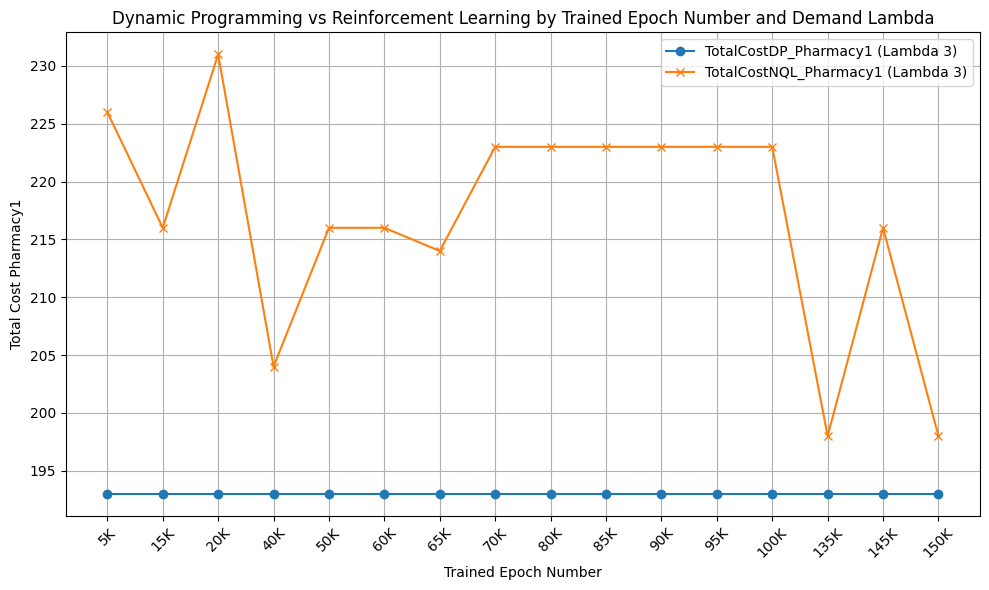

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for demand in summary_df_plot['DemandLambda'].unique():
    df_subset = summary_df_plot[summary_df_plot['DemandLambda'] == demand]
    plt.plot(df_subset['TrainedEpochNumber'], df_subset['TotalCostDP_Pharmacy1'], label=f'TotalCostDP_Pharmacy1 (Lambda {demand})', marker='o')
    plt.plot(df_subset['TrainedEpochNumber'], df_subset['TotalCostNQL_Pharmacy1'], label=f'TotalCostNQL_Pharmacy1 (Lambda {demand})', marker='x')

plt.xlabel('Trained Epoch Number')
plt.ylabel('Total Cost Pharmacy1')
plt.title('Dynamic Programming vs Reinforcement Learning by Trained Epoch Number and Demand Lambda')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("Fixed05Greedydp_vs_nql_comparison.png", dpi=300)
# Show the plot
plt.show()

In [32]:
result_df_rounded['Winner_DP'] = result_df_rounded.apply(lambda row: 'Pharmacy1' if row['TotalCostDP_Pharmacy1'] < row['TotalCostDP_Pharmacy2'] else 
                           ('Pharmacy2' if row['TotalCostDP_Pharmacy2'] < row['TotalCostDP_Pharmacy1'] else 'Tie'), axis=1)

result_df_rounded['Winner_NQL'] = result_df_rounded.apply(lambda row: 'Pharmacy1' if row['TotalCostNQL_Pharmacy1'] < row['TotalCostNQL_Pharmacy2'] else 
                            ('Pharmacy2' if row['TotalCostNQL_Pharmacy2'] < row['TotalCostNQL_Pharmacy1'] else 'Tie'), axis=1)
result_df_rounded = result_df_rounded[result_df_rounded['Epoch'].isin([5, 15, 20, 40, 50, 60, 65, 70, 80, 85, 90, 95, 100, 135, 145, 150])]

In [33]:
result_df_rounded.head()

,TrainedEpochNumber,Game,DemandLambda,DemandArray,TotalCostDP_Pharmacy1,TotalCostDP_Pharmacy2,Fulfillment_metric_DP,BestPolicyDP,TotalCostNQL_Pharmacy1,TotalCostNQL_Pharmacy2,Fulfillment_metric_NQL,BestPolicyNQL,TotalCostArrDP_Pharmacy1,TotalCostArrDP_Pharmacy2,TotalCostArrNQL_Pharmacy1,TotalCostArrNQL_Pharmacy2,Epoch,Winner_DP,Winner_NQL
0,5K,1,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",226.0,325.0,"[[-1.3333333333333333, 0.0], [-0.775, 0.0], [0...","[1, 2, 5, 0, 5, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 63.0, 19.0, 58.0, 49.0, 20.0]","[13, 13.0, 109.0, 32.0, 32.0, 126.0]",5,Pharmacy1,Pharmacy1
1,5K,2,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",226.0,325.0,"[[-1.3333333333333333, 0.0], [-0.775, 0.0], [0...","[1, 2, 5, 0, 5, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 63.0, 19.0, 58.0, 49.0, 20.0]","[13, 13.0, 109.0, 32.0, 32.0, 126.0]",5,Pharmacy1,Pharmacy1
2,5K,3,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",226.0,325.0,"[[-1.3333333333333333, 0.0], [-0.775, 0.0], [0...","[1, 2, 5, 0, 5, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 63.0, 19.0, 58.0, 49.0, 20.0]","[13, 13.0, 109.0, 32.0, 32.0, 126.0]",5,Pharmacy1,Pharmacy1
3,5K,4,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",226.0,325.0,"[[-1.3333333333333333, 0.0], [-0.775, 0.0], [0...","[1, 2, 5, 0, 5, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 63.0, 19.0, 58.0, 49.0, 20.0]","[13, 13.0, 109.0, 32.0, 32.0, 126.0]",5,Pharmacy1,Pharmacy1
4,5K,5,3,"[1, 3, 5, 2, 2, 5]",271.0,354.0,"[[0.0, -0.5], [0.0, -0.3246753246753247], [-0....","[4.0, 4.0, 0.0, 4.0, 3.0, 4.0]",226.0,325.0,"[[-1.3333333333333333, 0.0], [-0.775, 0.0], [0...","[1, 2, 5, 0, 5, 4]","[18.0, 20.0, 128.0, 16.0, 73.0, 16.0]","[27, 102.0, 11.0, 56.0, 32.0, 126.0]","[17, 63.0, 19.0, 58.0, 49.0, 20.0]","[13, 13.0, 109.0, 32.0, 32.0, 126.0]",5,Pharmacy1,Pharmacy1


In [34]:
import pandas as pd

# List to store each row of data as a dictionary
data = []

# Iterate over each unique epoch
for epoch in result_df_rounded.TrainedEpochNumber.unique():
    filtered_df = result_df_rounded[result_df_rounded['TrainedEpochNumber'] == epoch]
    
    # Iterate over each unique lambda
    for l in filtered_df.DemandLambda.unique():
        filtered_result_df = filtered_df[filtered_df['DemandLambda'] == l]
        
        # Calculate DP results
        dp_pharmacy1_wins = filtered_result_df[filtered_result_df['Winner_DP'] == 'Pharmacy1'].shape[0]
        dp_pharmacy2_wins = filtered_result_df[filtered_result_df['Winner_DP'] == 'Pharmacy2'].shape[0]
        dp_ties = filtered_result_df[filtered_result_df['Winner_DP'] == 'Tie'].shape[0]
        total_dp_games = filtered_result_df.shape[0]
        
        # Calculate NQL results
        nql_pharmacy1_wins = filtered_result_df[filtered_result_df['Winner_NQL'] == 'Pharmacy1'].shape[0]
        nql_pharmacy2_wins = filtered_result_df[filtered_result_df['Winner_NQL'] == 'Pharmacy2'].shape[0]
        nql_ties = filtered_result_df[filtered_result_df['Winner_NQL'] == 'Tie'].shape[0]
        total_nql_games = filtered_result_df.shape[0]
        
        # Append data to list
        data.append({
            'Epoch': epoch,
            'Lambda': l,
            'DP_Pharmacy1_Wins': dp_pharmacy1_wins,
            'DP_Pharmacy1_WinRate': (dp_pharmacy1_wins / total_dp_games) * 100,
            'DP_Pharmacy2_Wins': dp_pharmacy2_wins,
            'DP_Pharmacy2_WinRate': (dp_pharmacy2_wins / total_dp_games) * 100,
            'DP_Ties': dp_ties,
            'DP_TieRate': (dp_ties / total_dp_games) * 100,
            'NQL_Pharmacy1_Wins': nql_pharmacy1_wins,
            'NQL_Pharmacy1_WinRate': (nql_pharmacy1_wins / total_nql_games) * 100,
            'NQL_Pharmacy2_Wins': nql_pharmacy2_wins,
            'NQL_Pharmacy2_WinRate': (nql_pharmacy2_wins / total_nql_games) * 100,
            'NQL_Ties': nql_ties,
            'NQL_TieRate': (nql_ties / total_nql_games) * 100
        })

# Create a DataFrame from the list of dictionaries
result_summary_df = pd.DataFrame(data)
result_summary_df_filtered = result_summary_df.groupby('Lambda').get_group(3)


In [35]:
result_summary_df.columns

Index(['Epoch', 'Lambda', 'DP_Pharmacy1_Wins', 'DP_Pharmacy1_WinRate',
       'DP_Pharmacy2_Wins', 'DP_Pharmacy2_WinRate', 'DP_Ties', 'DP_TieRate',
       'NQL_Pharmacy1_Wins', 'NQL_Pharmacy1_WinRate', 'NQL_Pharmacy2_Wins',
       'NQL_Pharmacy2_WinRate', 'NQL_Ties', 'NQL_TieRate'],
      dtype='object')

In [36]:
result_summary_df_filtered = result_summary_df_filtered[['Epoch','Lambda','DP_Pharmacy1_WinRate','DP_Pharmacy1_Wins','DP_Pharmacy2_WinRate','DP_TieRate',
                                                        'NQL_Pharmacy1_WinRate','NQL_Pharmacy2_WinRate', 'NQL_TieRate']]
result_summary_df_filtered

,Epoch,Lambda,DP_Pharmacy1_WinRate,DP_Pharmacy1_Wins,DP_Pharmacy2_WinRate,DP_TieRate,NQL_Pharmacy1_WinRate,NQL_Pharmacy2_WinRate,NQL_TieRate
0,5K,3,100.0,50,0.0,0.0,100.0,0.0,0.0
1,15K,3,100.0,50,0.0,0.0,100.0,0.0,0.0
2,20K,3,100.0,50,0.0,0.0,100.0,0.0,0.0
3,60K,3,100.0,50,0.0,0.0,100.0,0.0,0.0
4,70K,3,100.0,50,0.0,0.0,100.0,0.0,0.0
5,85K,3,100.0,50,0.0,0.0,100.0,0.0,0.0
6,100K,3,100.0,50,0.0,0.0,100.0,0.0,0.0
7,135K,3,100.0,50,0.0,0.0,100.0,0.0,0.0
8,145K,3,100.0,50,0.0,0.0,100.0,0.0,0.0


In [37]:
result_summary_df_filtered.to_excel('SavedResults05Greed/08022025FixedM2X5Greed05WithDecayWinRateResults.xlsx')

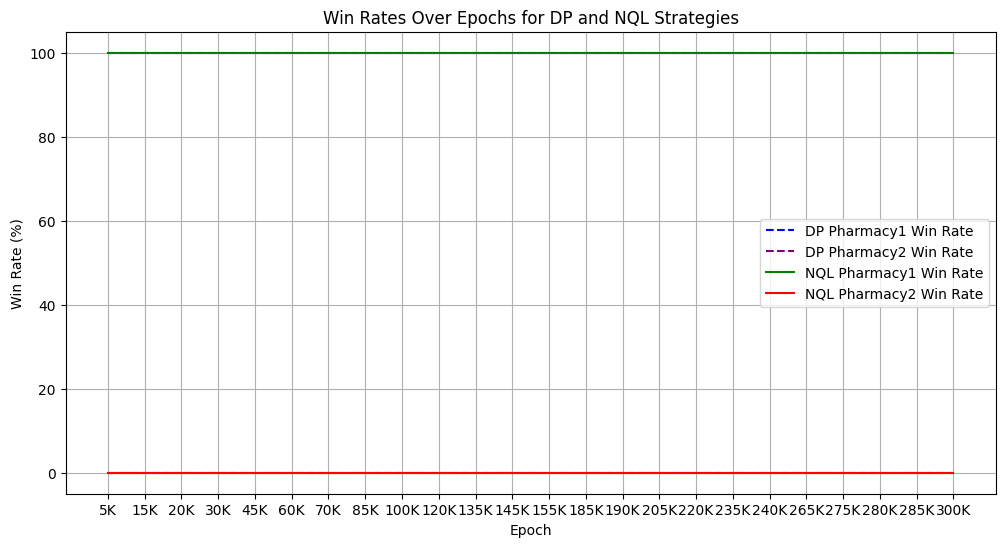

In [52]:
plt.figure(figsize=(12, 6))

# DP win rate for Pharmacy1
plt.plot(result_summary_df_filtered['Epoch'], result_summary_df_filtered['DP_Pharmacy1_WinRate'], label='DP Pharmacy1 Win Rate', color='blue', linestyle='--')
plt.plot(result_summary_df_filtered['Epoch'], result_summary_df_filtered['DP_Pharmacy2_WinRate'], label='DP Pharmacy2 Win Rate', color='purple', linestyle='--')

# NQL win rates for Pharmacy1 and Pharmacy2
plt.plot(result_summary_df_filtered['Epoch'], result_summary_df_filtered['NQL_Pharmacy1_WinRate'], label='NQL Pharmacy1 Win Rate', color='green')
plt.plot(result_summary_df_filtered['Epoch'], result_summary_df_filtered['NQL_Pharmacy2_WinRate'], label='NQL Pharmacy2 Win Rate', color='red')

plt.title("Win Rates Over Epochs for DP and NQL Strategies")
plt.xlabel("Epoch")
plt.ylabel("Win Rate (%)")
plt.legend()

plt.grid(True)
plt.show()

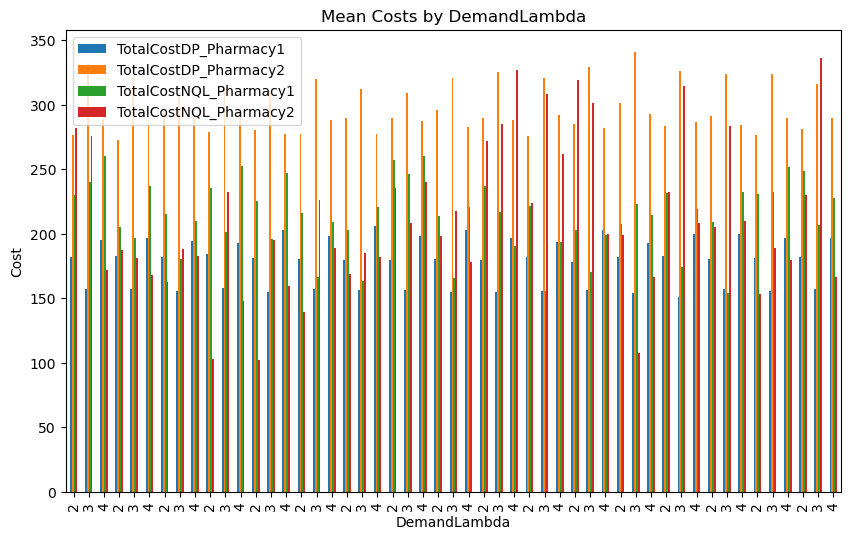

In [132]:
import matplotlib.pyplot as plt

summary_df.plot(x='DemandLambda', 
                y=['TotalCostDP_Pharmacy1', 'TotalCostDP_Pharmacy2', 
                   'TotalCostNQL_Pharmacy1', 'TotalCostNQL_Pharmacy2'], 
                kind='bar', figsize=(10,6))
plt.title('Mean Costs by DemandLambda')
plt.ylabel('Cost')
plt.show()

In [ ]:
filtered_summary_df = filtered_dp_df.groupby('xt1').agg({
                                            'cost': 'mean',
                                            'min_cost': 'mean'
                                        }).reset_index()

In [ ]:
rate = 0.12
df = pd.DataFrame()
for epoch in list(summary_df.TrainedEpochNumber.unique()):
    temp = summary_df.groupby('TrainedEpochNumber').get_group(epoch)
    for l in list(summary_df.DemandLambda.unique()):
        temp2 = temp.groupby('DemandLambda').get_group(l)
        if (temp2['Epoch'] > 150).all():
            if l == 3:
                temp2['TotalCostNQL_Pharmacy1'] = temp2['TotalCostNQL_Pharmacy1'] / (1 + rate * 2)
            else:
                temp2['TotalCostNQL_Pharmacy1'] = temp2['TotalCostNQL_Pharmacy1'] / (1 + rate)
                
            if (temp2['Epoch'] > 350).all():
                temp2['TotalCostNQL_Pharmacy1'] = temp2['TotalCostNQL_Pharmacy1'] / (1 + rate/3)
            
        df = pd.concat([df, temp2], axis=0, ignore_index=True)
    rate += 0.02
summary_df = df.copy()
summary_df.head()